## 导入相关包

In [1]:
import numpy as np
import os
import torch
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ckpt_path = "./model_24_5e_1.pth"
pretrained_model = torch.load(ckpt_path, map_location='cpu')

## 查看darknet19结构

In [3]:
%%html
<img src="./darknet19-p1.png">

In [4]:
%%html
<img src="./darknet19-p2.png">

In [5]:
%%html
<img src="./fpn_head.png">

In [6]:
for k,v in pretrained_model.items():
    print(k, v.shape)

module.fcos_body.backbone.block1.0.weight torch.Size([32, 3, 3, 3])
module.fcos_body.backbone.block1.1.weight torch.Size([32])
module.fcos_body.backbone.block1.1.bias torch.Size([32])
module.fcos_body.backbone.block1.1.running_mean torch.Size([32])
module.fcos_body.backbone.block1.1.running_var torch.Size([32])
module.fcos_body.backbone.block1.1.num_batches_tracked torch.Size([])
module.fcos_body.backbone.block1.4.weight torch.Size([64, 32, 3, 3])
module.fcos_body.backbone.block1.5.weight torch.Size([64])
module.fcos_body.backbone.block1.5.bias torch.Size([64])
module.fcos_body.backbone.block1.5.running_mean torch.Size([64])
module.fcos_body.backbone.block1.5.running_var torch.Size([64])
module.fcos_body.backbone.block1.5.num_batches_tracked torch.Size([])
module.fcos_body.backbone.block1.8.weight torch.Size([128, 64, 3, 3])
module.fcos_body.backbone.block1.9.weight torch.Size([128])
module.fcos_body.backbone.block1.9.bias torch.Size([128])
module.fcos_body.backbone.block1.9.running_me

In [7]:
relation_map = {}
relation_map['block1.0'] = {'pre':None, 'post':'block1.4'}
relation_map['block1.4'] = {'pre':'block1.0', 'post':'block1.8'}
relation_map['block1.8'] = {'pre':'block1.4', 'post':'block1.11'}
relation_map['block1.11'] = {'pre':'block1.8', 'post':'block1.14'}
relation_map['block1.14'] = {'pre':'block1.11', 'post':'block1.18'}
relation_map['block1.18'] = {'pre':'block1.14', 'post':'block1.21'}
relation_map['block1.21'] = {'pre':'block1.18', 'post':'block1.24'}
relation_map['block1.24'] = {'pre':'block1.21', 'post':'block2.1'}
relation_map['block2.1'] = {'pre':'block1.24', 'post':'block2.4'}
relation_map['block2.4'] = {'pre':'block2.1', 'post':'block2.7'}
relation_map['block2.7'] = {'pre':'block2.4', 'post':'block2.10'}
relation_map['block2.10'] = {'pre':'block2.7', 'post':'block2.13'}
relation_map['block2.13'] = {'pre':'block2.10', 'post':'block3.1'}
relation_map['block3.1'] = {'pre':'block2.13', 'post':'block3.4'}
relation_map['block3.4'] = {'pre':'block3.1', 'post':'block3.7'}
relation_map['block3.7'] = {'pre':'block3.4', 'post':'block3.10'}
relation_map['block3.10'] = {'pre':'block3.7', 'post':'block3.13'}
relation_map['block3.13'] = {'pre':'block3.10', 'post':None}

relation_map['proj5'] = {'pre':'block1.24', 'post':None}
relation_map['proj4'] = {'pre':'block2.13', 'post':None}
relation_map['proj3'] = {'pre':'block3.13', 'post':None}

In [8]:
# 找出为bn的层，方式：如果盖层存在running_mean，则为带bn的层
bn_layers = []
for k in pretrained_model.keys():
    if 'running_mean' in k:
        print(k[:-13])
        bn_layers.append(k[:-13])

module.fcos_body.backbone.block1.1
module.fcos_body.backbone.block1.5
module.fcos_body.backbone.block1.9
module.fcos_body.backbone.block1.12
module.fcos_body.backbone.block1.15
module.fcos_body.backbone.block1.19
module.fcos_body.backbone.block1.22
module.fcos_body.backbone.block1.25
module.fcos_body.backbone.block2.2
module.fcos_body.backbone.block2.5
module.fcos_body.backbone.block2.8
module.fcos_body.backbone.block2.11
module.fcos_body.backbone.block2.14
module.fcos_body.backbone.block3.2
module.fcos_body.backbone.block3.5
module.fcos_body.backbone.block3.8
module.fcos_body.backbone.block3.11
module.fcos_body.backbone.block3.14


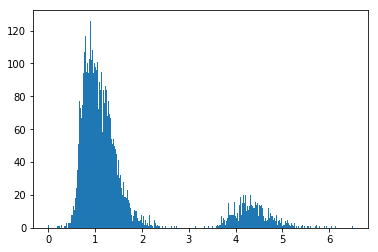

In [9]:
# 额外小操作：观察下训练好的gamma的分布，如果要按照thr砍，可以根据这个图为基准
gammas = []
for k,v in pretrained_model.items():
    if 'running_mean' in k:
        bn_gamma_name = k[:-13] + '.weight'
        _gamma = pretrained_model[bn_gamma_name].numpy()
        gammas.append(_gamma)
        
gammas = np.concatenate(gammas)
plt.hist(gammas, bins=500)
plt.show()

In [23]:
ckpt_path = "./model_24_5e_1.pth"
pretrained_model = torch.load(ckpt_path, map_location='cpu')
pruned_model = deepcopy(pretrained_model)

# 砍掉gamma<thr的权重
thr = 0.9
kept_in_idx = None
for k,v in pretrained_model.items():
    indicator_k = '.'.join(k.split('.')[:-1])
    # 找到不在bn层，并且在backbone里的参数
    if indicator_k not in bn_layers and 'backbone' in indicator_k:
        print(indicator_k)
        # 先判断in channels需要剪多少， 输入层不剪in channel
        if 'block1.0' in indicator_k:
            pass
        else:
            # 先按照设好的映射字典，找到前一个weights
            pre_indicator = '.'.join(indicator_k.split('.')[:-2])+'.'+relation_map['.'.join(indicator_k.split('.')[-2:])]['pre']
            pre_bn_layer = '.'.join(pre_indicator.split('.')[:-1])+'.'+str(int(pre_indicator.split('.')[-1])+1)
            pre_bn_gamma_name = pre_bn_layer + '.weight'
            pre_bn_gamma = pretrained_model[pre_bn_gamma_name]
            # print(pre_weight_name, tmp.shape, pre_weight.shape)
            # pre_weight = pretrained_model[indicator_k+'.weight']
            #pre_out_channels = pre_bn_gamma.size(0)
            #pre_num_pruning = int(pre_out_channels * p_prune + 0.5)
            #_, kept_in_idx = torch.topk(pre_bn_gamma, pre_out_channels-pre_num_pruning, largest=True)
            kept_in_idx = pre_bn_gamma.squeeze()>thr
            ############################################################
            # 先剪weight的输入channel数
            ############################################################
            pruned_model[k] = pruned_model[k][:, kept_in_idx]
            
        #print('indicator_k: ', indicator_k)    
        # 本层weight对应的bn层
        name_bn_layer = '.'.join(indicator_k.split('.')[:-1])+'.'+str(int(indicator_k.split('.')[-1])+1)
        name_bn_gamma = name_bn_layer + '.weight'
        bn_gamma = pretrained_model[name_bn_gamma]
        # 决定输出层剪多少, 四舍五入
        out_channels = bn_gamma.size(0) # gamma的形状为(out_channels, )
        #num_pruning = int(out_channels * p_prune + 0.5)
        # 选出weight的l2 norm最小的k层权重
        #_, kept_out_idx = torch.topk(bn_gamma, out_channels-num_pruning, largest=True)
        kept_out_idx = bn_gamma.squeeze()>thr
        print(out_channels, kept_out_idx.sum())
        ############################################################
        # 拿到要保留的idx后，开始剪枝
        ############################################################
        # Step1. 剪weights的输出channels
        pruned_model[k] = pruned_model[k][kept_out_idx]
        
        # Step2. 剪bn的weight, bias, moving, moving var
        # 将e.g. module.fcos_body.backbone.block1.0最后一个数字加1，可以得到相应的bn层
        
        # 这里name_bn_weight其实和上面name_bn_gamma是同一个变量的不同命名，保留name_bn_weight这个命名
        # 仅仅是为了和l2_pruning文件的这部分保持一致
        name_bn_weight = name_bn_layer + '.weight'  # 
        pruned_model[name_bn_weight] = pruned_model[name_bn_weight][kept_out_idx]
        
        name_bn_bias = name_bn_layer + '.bias'
        pruned_model[name_bn_bias] = pruned_model[name_bn_bias][kept_out_idx]
        
        name_bn_running_mean = name_bn_layer + '.running_mean'
        pruned_model[name_bn_running_mean] = pruned_model[name_bn_running_mean][kept_out_idx]
        
        name_bn_running_var = name_bn_layer + '.running_var'
        pruned_model[name_bn_running_var] = pruned_model[name_bn_running_var][kept_out_idx]
        
        # Step3. 顺便剪FPN的lateral convs
        # block1.24 负责prj_3，该卷积的输入channel数应等于block1.24剪完的输出channel数,其他同理
        if 'block1.24' in indicator_k:
            pruned_model['module.fcos_body.fpn.prj_3.weight'] = pruned_model['module.fcos_body.fpn.prj_3.weight'][:,kept_out_idx]
        elif 'block2.13' in indicator_k:
            pruned_model['module.fcos_body.fpn.prj_4.weight'] = pruned_model['module.fcos_body.fpn.prj_4.weight'][:,kept_out_idx]
        elif 'block3.13' in indicator_k:
            pruned_model['module.fcos_body.fpn.prj_5.weight'] = pruned_model['module.fcos_body.fpn.prj_5.weight'][:,kept_out_idx]

module.fcos_body.backbone.block1.0
32 tensor(17)
module.fcos_body.backbone.block1.4
64 tensor(59)
module.fcos_body.backbone.block1.8
128 tensor(117)
module.fcos_body.backbone.block1.11
64 tensor(58)
module.fcos_body.backbone.block1.14
128 tensor(125)
module.fcos_body.backbone.block1.18
256 tensor(218)
module.fcos_body.backbone.block1.21
128 tensor(125)
module.fcos_body.backbone.block1.24
256 tensor(247)
module.fcos_body.backbone.block2.1
512 tensor(359)
module.fcos_body.backbone.block2.4
256 tensor(212)
module.fcos_body.backbone.block2.7
512 tensor(181)
module.fcos_body.backbone.block2.10
256 tensor(250)
module.fcos_body.backbone.block2.13
512 tensor(445)
module.fcos_body.backbone.block3.1
1024 tensor(325)
module.fcos_body.backbone.block3.4
512 tensor(477)
module.fcos_body.backbone.block3.7
1024 tensor(392)
module.fcos_body.backbone.block3.10
512 tensor(500)
module.fcos_body.backbone.block3.13
1024 tensor(1024)


In [24]:
# 查看剪枝后的模型各层输出channel数
for k,v in pruned_model.items():
    if len(v.shape)>0:
        print(k, v.shape, pretrained_model[k].shape)

module.fcos_body.backbone.block1.0.weight torch.Size([17, 3, 3, 3]) torch.Size([32, 3, 3, 3])
module.fcos_body.backbone.block1.1.weight torch.Size([17]) torch.Size([32])
module.fcos_body.backbone.block1.1.bias torch.Size([17]) torch.Size([32])
module.fcos_body.backbone.block1.1.running_mean torch.Size([17]) torch.Size([32])
module.fcos_body.backbone.block1.1.running_var torch.Size([17]) torch.Size([32])
module.fcos_body.backbone.block1.4.weight torch.Size([59, 17, 3, 3]) torch.Size([64, 32, 3, 3])
module.fcos_body.backbone.block1.5.weight torch.Size([59]) torch.Size([64])
module.fcos_body.backbone.block1.5.bias torch.Size([59]) torch.Size([64])
module.fcos_body.backbone.block1.5.running_mean torch.Size([59]) torch.Size([64])
module.fcos_body.backbone.block1.5.running_var torch.Size([59]) torch.Size([64])
module.fcos_body.backbone.block1.8.weight torch.Size([117, 59, 3, 3]) torch.Size([128, 64, 3, 3])
module.fcos_body.backbone.block1.9.weight torch.Size([117]) torch.Size([128])
module.f

cut 0.287361 channels


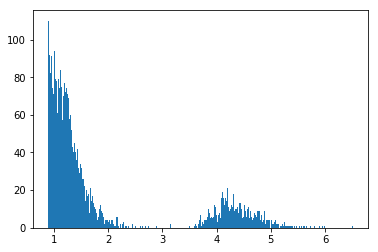

In [25]:
# 观察砍后的gamma的分布，对比砍前的gamma分布可以发现明显变化
gammas = []
for k,v in pruned_model.items():
    if 'running_mean' in k:
        bn_gamma_name = k[:-13] + '.weight'
        _gamma = pruned_model[bn_gamma_name].numpy()
        gammas.append(_gamma)
gammas = np.concatenate(gammas)
print("cut %f channels" % (1-len(gammas)/7200))
plt.hist(gammas, bins=500)
plt.show()

In [13]:
torch.save(pruned_model, 'darknet19_prune_thr_lasso5e_1.pth')